---
title: "Regression"
format:
  html:
    code-fold: true
---

In [71]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.model_selection import train_test_split

In [72]:
happydf = pd.read_csv("../websitedata/happy_py.csv")

appdf = pd.read_csv("../websitedata/apple_py.csv")

In [73]:
happydf = happydf.sort_values(by="Score", ascending=True)
happydf = happydf.drop(columns={"Unnamed: 0", "Code"}, axis=1)
happy20 = pd.concat([happydf.head(20), happydf.tail(20)])
happy20 = happy20.rename(columns={"Entity": "CountryHappy"})

happy20 = happy20.sort_values(by=["CountryHappy"])
happy20 = happy20.reset_index(drop=True)
#print(happy20)
print(happy20.head)

<bound method NDFrame.head of                     CountryHappy   Score         GDP
0                    Afghanistan  1.8590       363.7
1                      Australia  7.0946   64,491.40
2                        Austria  7.0973   52,131.40
3                     Bangladesh  4.2821    2,688.30
4                        Belgium  6.8591   49,582.80
5                       Botswana  3.4353    7,737.70
6                         Canada  6.9607   54,966.50
7                        Comoros  3.5452    1,484.90
8                        Czechia  6.8452   27,638.40
9   Democratic Republic of Congo  3.2072       586.5
10                       Denmark  7.5864   66,983.10
11                         Egypt  4.1705    4,295.40
12                      Ethiopia  4.0906    1,027.60
13                       Finland  7.8042   50,536.60
14                        Gambia  4.2794         840
15                       Germany  6.8918   48,432.50
16                       Iceland  7.5296   72,903.00
17              

In [74]:
country_mapping = {
    "US": "United States",'UK': 'United Kingdom','JP': 'Japan','DE': 'Germany','AU': 'Australia','CA': 'Canada',
    'FR': 'France','IT': 'Italy','KR': 'South Korea','MX': 'Mexico','TH': 'Thailand','BE': 'Belgium','BR': 'Brazil',
    'CH': 'Switzerland','CN': 'China','CO': 'Colombia','ES': 'Spain','HK': 'Hong Kong','ID': 'Indonesia',
    'IE': 'Ireland','IN': 'India','NL': 'Netherlands','NZ': 'New Zealand','TR': 'Turkey','TW': 'Taiwan','ZA': 'South Africa',
    'AE': 'United Arab Emirates','AR': 'Argentina','AT': 'Austria','CL': 'Chile','CZ': 'Czech Republic','DK': 'Denmark',
    'EE': 'Estonia','EG': 'Egypt','FI': 'Finland','GR': 'Greece','HU': 'Hungary','IL': 'Israel','KE': 'Kenya','KZ': 'Kazakhstan',
    'LB': 'Lebanon','LT': 'Lithuania','LU': 'Luxembourg','MY': 'Malaysia','NG': 'Nigeria','NO': 'Norway','PE': 'Peru',
    'PH': 'Philippines','PL': 'Poland','PT': 'Portugal','RO': 'Romania','SA': 'Saudi Arabia','SE': 'Sweden',
    'SI': 'Slovenia','SG': 'Singapore','SK': 'Slovakia','UA': 'Ukraine','VN': 'Vietnam'}
appdf["Country"] = appdf["Country"].map(country_mapping)

appdf = appdf.loc[(appdf["Peak"] == 1)]
appdf = appdf.drop_duplicates(subset="Country", keep="last") #did last bc first was all Doja Cat and want to see some variation
appdf = appdf.drop(columns={"Unnamed: 0"})

appdf = appdf.head(40)

appdf = appdf.sort_values(by=["Country"])
appdf = appdf.reset_index(drop=True)

print(appdf.head)

<bound method NDFrame.head of     Chart Position                    Artist and Title  Position Duration  \
0              198  Elton John & Dua Lipa - Cold Heart                787   
1              198  Elton John & Dua Lipa - Cold Heart                787   
2               84             Travis Scott - MELTDOWN                 76   
3              126                Ed Sheeran - Perfect               1982   
4              198  Elton John & Dua Lipa - Cold Heart                787   
5              126                Ed Sheeran - Perfect               1982   
6                7         Taylor Swift - Cruel Summer                245   
7                7         Taylor Swift - Cruel Summer                245   
8               42            Harry Styles - As It Was                559   
9              126                Ed Sheeran - Perfect               1982   
10             198  Elton John & Dua Lipa - Cold Heart                787   
11              84             Travis Scott - 

In [75]:
# Concatenate then vectorize countries
print(appdf.shape)
happymusicdf = pd.concat([happy20, appdf],axis=1)
print(happymusicdf.shape)
print(happymusicdf.keys())
print(happymusicdf.head)

(40, 8)
(40, 11)
Index(['CountryHappy', 'Score', 'GDP', 'Chart Position', 'Artist and Title',
       'Position Duration', 'Peak', '(x?)', 'Points', 'Country',
       'Country Rank'],
      dtype='object')
<bound method NDFrame.head of                     CountryHappy   Score         GDP  Chart Position  \
0                    Afghanistan  1.8590       363.7             198   
1                      Australia  7.0946   64,491.40             198   
2                        Austria  7.0973   52,131.40              84   
3                     Bangladesh  4.2821    2,688.30             126   
4                        Belgium  6.8591   49,582.80             198   
5                       Botswana  3.4353    7,737.70             126   
6                         Canada  6.9607   54,966.50               7   
7                        Comoros  3.5452    1,484.90               7   
8                        Czechia  6.8452   27,638.40              42   
9   Democratic Republic of Congo  3.2072     

In [76]:
happysongsdf = happymusicdf[happymusicdf["CountryHappy"] == happymusicdf["Country"]]
happysongsdf["GDP"] = pd.to_numeric(happysongsdf["GDP"].str.replace(',', ''), errors='coerce')
print(happysongsdf.shape)
print(happysongsdf.head)

#happysongsdf.to_csv("../websitedata/happyCountryMatch.csv")

(9, 11)
<bound method NDFrame.head of    CountryHappy   Score      GDP  Chart Position  \
1     Australia  7.0946  64491.4             198   
2       Austria  7.0973  52131.4              84   
10      Denmark  7.5864  66983.1             198   
11        Egypt  4.1705   4295.4              84   
13      Finland  7.8042  50536.6             126   
15      Germany  6.8918  48432.5              84   
28  Netherlands  7.4030  55985.4             198   
29  New Zealand  7.1229  48249.3             198   
33  Switzerland  7.2401  92101.5             198   

                      Artist and Title  Position Duration  Peak  (x?)  Points  \
1   Elton John & Dua Lipa - Cold Heart                787     1    41    1056   
2              Travis Scott - MELTDOWN                 76     1     3    1860   
10  Elton John & Dua Lipa - Cold Heart                787     1    41    1056   
11             Travis Scott - MELTDOWN                 76     1     3    1860   
13                Ed Sheeran - Perfe

C:\Users\Amand\AppData\Local\Temp\ipykernel_19352\3590638393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  happysongsdf["GDP"] = pd.to_numeric(happysongsdf["GDP"].str.replace(',', ''), errors='coerce')


In [77]:
happysongs = happysongsdf.drop(columns={"Country", "CountryHappy", "Score", "Artist and Title"})
#happysongsdf = happysongsdf.rename(columns={"CountryHappy": "Country"})
print(happysongs)

        GDP  Chart Position  Position Duration  Peak  (x?)  Points  \
1   64491.4             198                787     1    41    1056   
2   52131.4              84                 76     1     3    1860   
10  66983.1             198                787     1    41    1056   
11   4295.4              84                 76     1     3    1860   
13  50536.6             126               1982     1     2    1446   
15  48432.5              84                 76     1     3    1860   
28  55985.4             198                787     1    41    1056   
29  48249.3             198                787     1    41    1056   
33  92101.5             198                787     1    41    1056   

    Country Rank  
1           43.0  
2          153.0  
10         124.0  
11          47.0  
13         158.0  
15         170.0  
28          99.0  
29          49.0  
33         122.0  


In [78]:
# SCORE AND CHART POSITION
X = happysongs
y = happysongsdf["Score"]
y = y.to_numpy()

print(X.shape)
print(y.shape)

(9, 7)
(9,)


In [79]:
from sklearn.model_selection import train_test_split

test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

print("x_train.shape        :",x_train.shape)
print("y_train.shape        :",y_train.shape)

print("X_test.shape     :",x_test.shape)
print("y_test.shape     :",y_test.shape)

x_train.shape        : (7, 7)
y_train.shape        : (7,)
X_test.shape     : (2, 7)
y_test.shape     : (2,)


In [80]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


# HYPER PARAMETER SEARCH FOR OPTIMAL NUMBER OF NEIGHBORS 
hyper_param=[]
train_error=[]
test_error=[]

# LOOP OVER HYPER-PARAM
for i in range(1,40):
    # INITIALIZE MODEL 
    model = DecisionTreeRegressor(max_depth=i)

    # TRAIN MODEL 
    model.fit(x_train,y_train)

    # OUTPUT PREDICTIONS FOR TRAINING AND TEST SET 
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)

    # shift=1+np.min(y_train) #add shift to remove division by zero 
    err1=mean_absolute_error(y_train, yp_train) 
    err2=mean_absolute_error(y_test, yp_test) 
    
    # err1=100.0*np.mean(np.absolute((yp_train-y_train)/y_train))
    # err2=100.0*np.mean(np.absolute((yp_test-y_test)/y_test))

    hyper_param.append(i)
    train_error.append(err1)
    test_error.append(err2)

    if(i==1 or i%10==0):
        print("hyperparam =",i)
        print(" train error:",err1)
        print(" test error:" ,err2)

hyperparam = 1
 train error: 0.19910476190476142
 test error: 0.23175000000000034
hyperparam = 10
 train error: 0.0
 test error: 0.28869999999999996
hyperparam = 20
 train error: 0.0
 test error: 0.18730000000000002
hyperparam = 30
 train error: 0.0
 test error: 0.18730000000000002


2 0.10067999999999991 0.23175000000000034


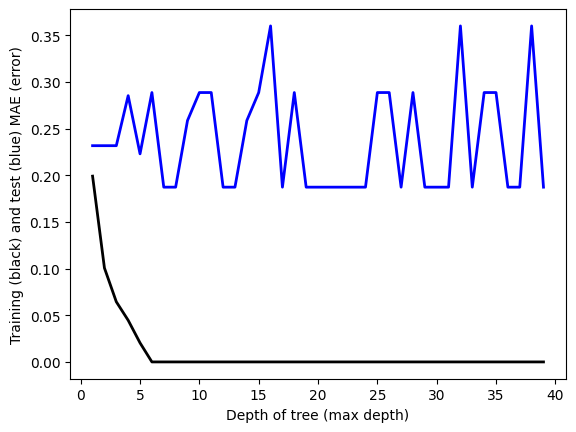

In [84]:
plt.plot(hyper_param,train_error ,linewidth=2, color='k')
plt.plot(hyper_param,test_error ,linewidth=2, color='b')

plt.xlabel("Depth of tree (max depth)")
plt.ylabel("Training (black) and test (blue) MAE (error)")

i=1
print(hyper_param[i],train_error[i],test_error[i])

In [81]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("TRAINING SHAPES:",x_train.shape,y_train.shape)
print("TEST SHAPES:",x_test.shape,y_test.shape)

TRAINING SHAPES: (6, 7) (6,)
TEST SHAPES: (3, 7) (3,)


In [85]:
# INITIALIZE MODEL 
model = DecisionTreeRegressor(max_depth=1)
model.fit(x_train,y_train)                     # TRAIN MODEL 


# OUTPUT PREDICTIONS FOR TRAINING AND TEST SET 
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

err1=mean_absolute_error(y_train, yp_train) 
err2=mean_absolute_error(y_test, yp_test) 
    
print(" train error:",err1)
print(" test error:" ,err2)

 train error: 0.21123999999999996
 test error: 0.217646666666667


My dataset was too small for a supervised learning project to yield an accurate analysis. However, my methodology was to run a regression model, where I combine the datasets for self- reported life satisfaction and apple music rankings and use the life satisfaction as the target variable. The decision tree produced 2 leaves, one with a value of 4.17 and another with a value of 7.287. 

Below, I produced a decision tree with some information on the success of the algorithm and a linear regression visualization. As the closer the predicted y and true y is to the line, this visualization shows the fit was not perfect, but luckily the data did not suffer from overfitting.


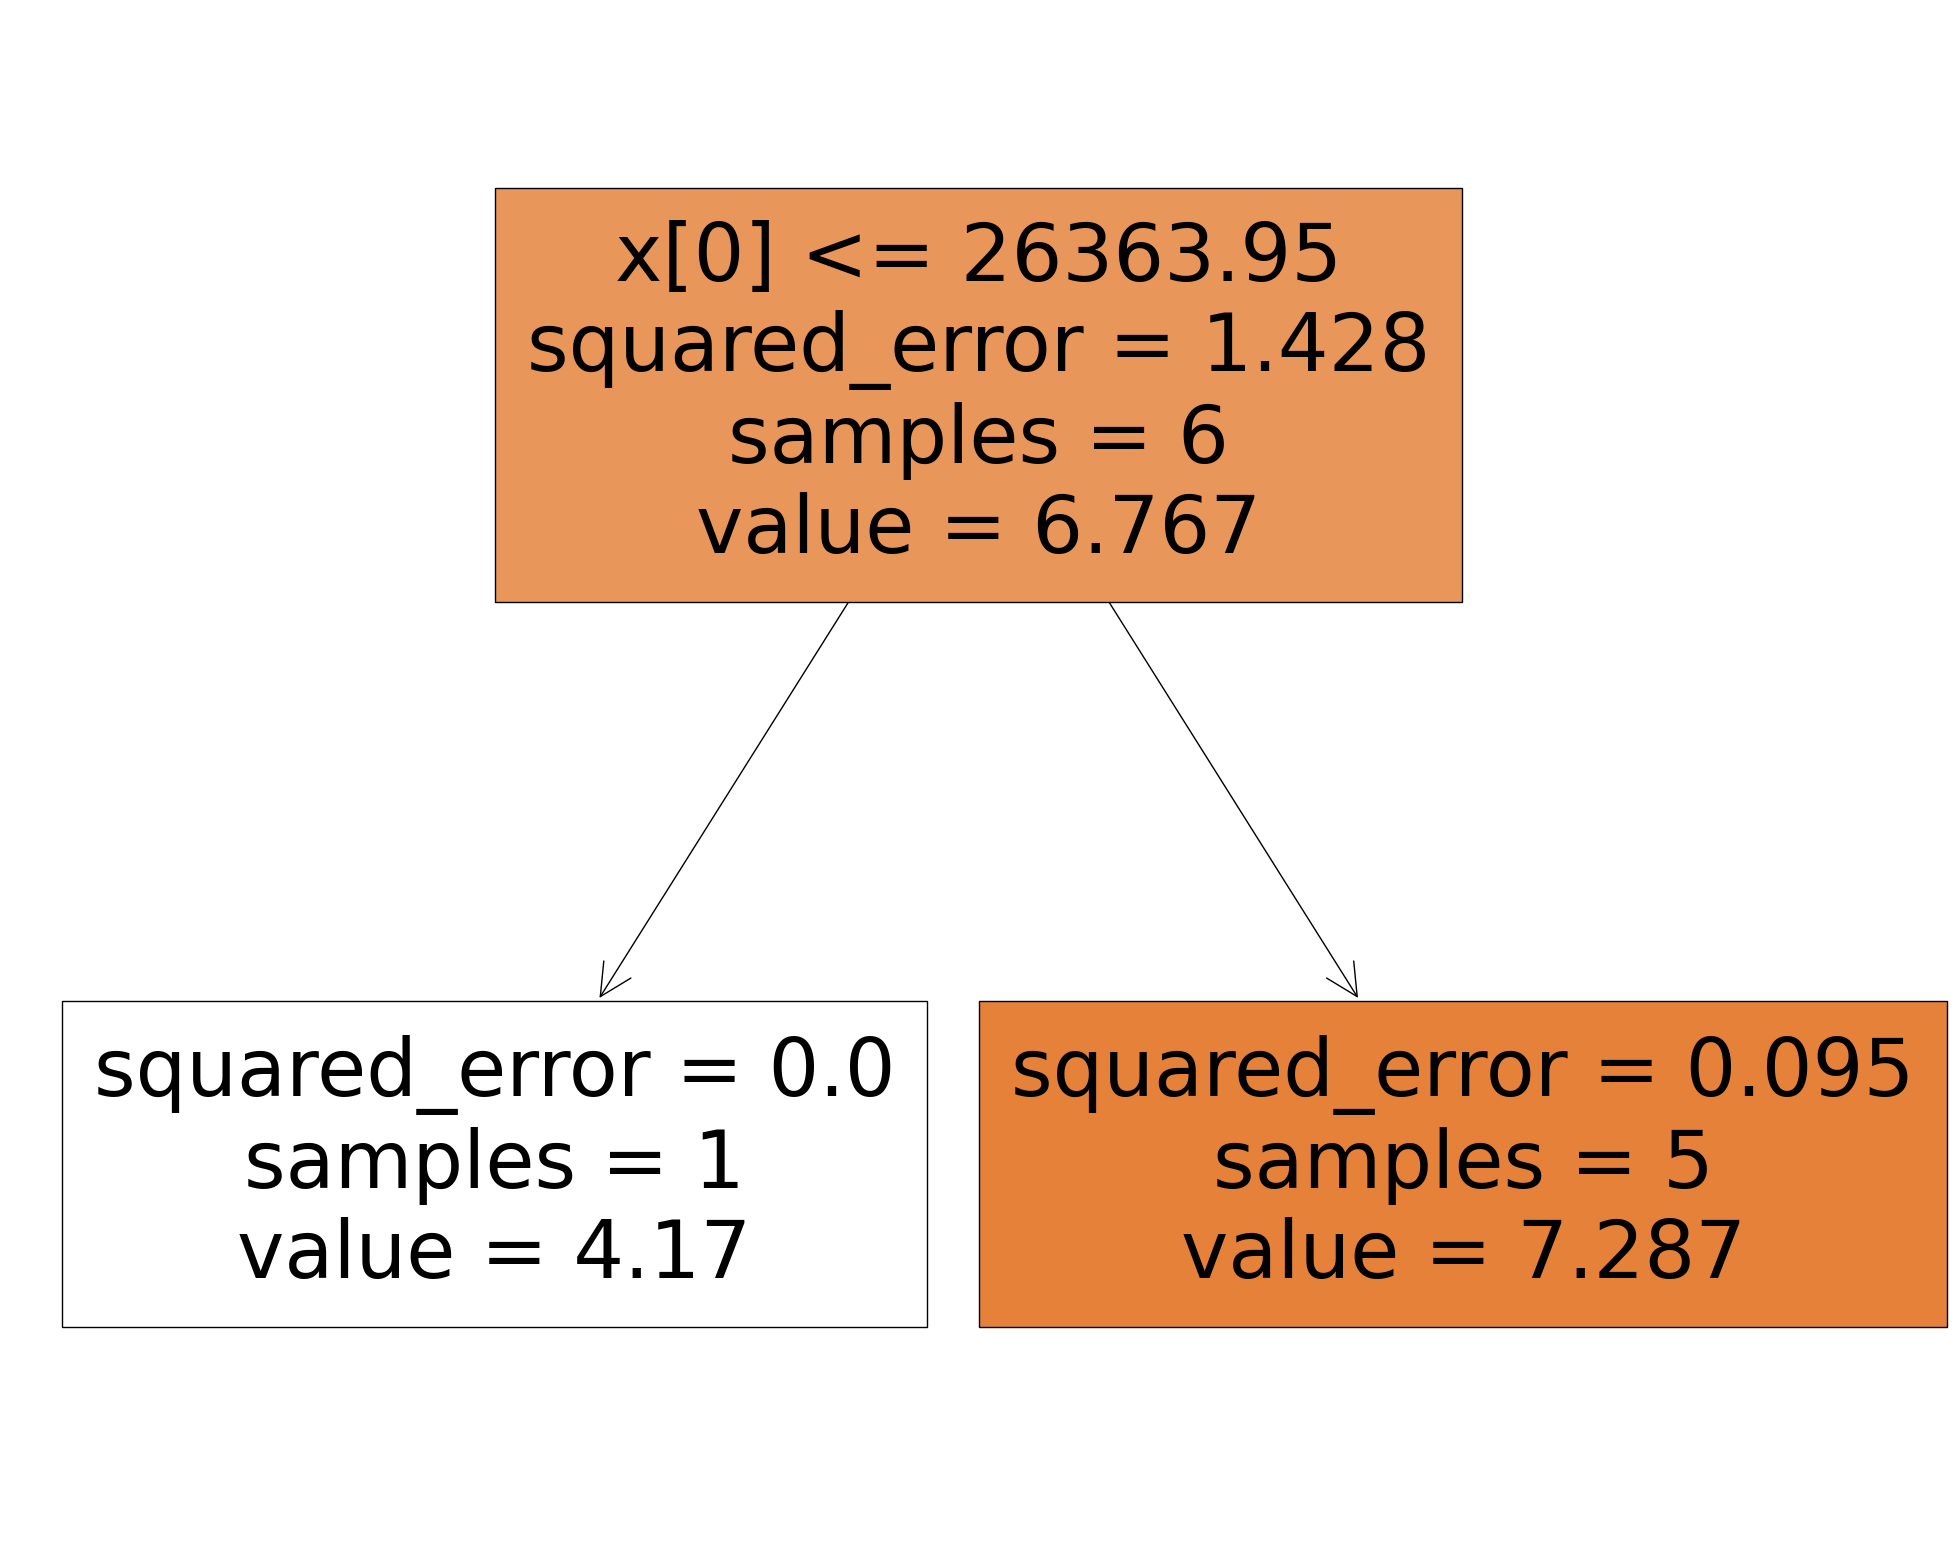

In [87]:
from sklearn import tree
def plot_tree(model):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(model, 
                    filled=True)
    plt.show()

plot_tree(model)

 train error: 5.476143871360148
 test error: 5.467027259259829


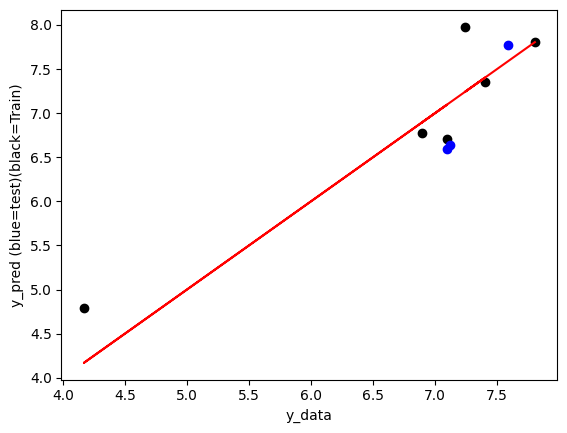

In [88]:
# LINEAR REGRESSION 
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)

# OUTPUT PREDICTIONS FOR TRAINING AND TEST SET 
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

plt.plot(y_train,yp_train ,"o", color='k')
plt.plot(y_test,yp_test ,"o", color='b')
plt.plot(y_train,y_train,"-", color='r')

plt.xlabel("y_data")
plt.ylabel("y_pred (blue=test)(black=Train)")

    
err1=100.0*np.mean(np.absolute((yp_train-y_train)/y_train))
err2=100.0*np.mean(np.absolute((yp_test-y_test)/y_test))

print(" train error:",err1)
print(" test error:" ,err2)